In [1]:
import copy
import os
import sys
from pathlib import Path

import numpy as np
from qutip.solver.floquet import progress_bars
import torch
from pulser import Pulse, Register, Sequence
from pulser.devices import MockDevice
from pulser_diff.backend import TorchEmulator
from pyqtorch.utils import SolverType
from torch import Tensor
import json
import time
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import h5py as h5

In [2]:
sys.path.append("../..")

In [3]:
from source.NAHEA_CNN import NAHEA_CNN_1

In [4]:
# load data from sin dataset
data_save_dir = Path("../../data") / "sin"
data_save_path_train = data_save_dir / "train.h5"
data_save_path_test = data_save_dir / "test.h5"

with h5.File(data_save_path_train, "r") as f:
    X_train = f["X"][:].squeeze(2)
    y_train = f["y"][:]

with h5.File(data_save_path_test, "r") as f:
    X_test = f["X"][:].squeeze(2)
    y_test = f["y"][:]

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (4000, 18)
y_train shape: (4000, 1)
X_test shape: (1000, 18)
y_test shape: (1000, 1)


In [8]:
n_train = 150
n_test = 500 # testing is much faster than training
X_train = X_train[:n_train]
y_train = y_train[:n_train]
X_test = X_test[:n_test]
y_test = y_test[:n_test]

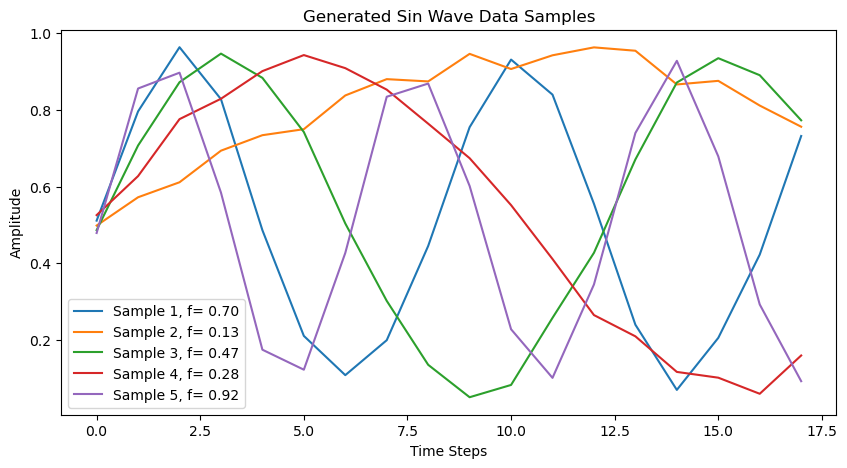

In [5]:
# plot some data
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.plot(X_train[i], label=f"Sample {i+1}, f= {y_train[i][0]:.2f}")
plt.title("Generated Sin Wave Data Samples")
plt.xlabel("Time Steps")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

In [7]:
seq_len = X_train.shape[1]
hparams = {
    "n_features": (n_features := 5),  # =1D kernel size = number of qubits
    "sampling_rate": 0.2,
    "protocol": "min-delay",
    "n_ancilliary_qubits": (n_ancilliary_qubits := 0), # not implemented
    "input_length": seq_len,
    "stride": 3,  # stride for the convolution
    "output_dim": 1,  # output dimension of the final FC NN
    "hidden_layers_dims": [10, 5],
}

sep = 7.0
parameters = {
    # separation of 7 between the qubits
    "positions": [[sep * i - (sep * 2), 0] for i in range(n_features)],
    "local_pulses_omega_1": [0.5, 1.0, 1.5, 1.0, 0.5],
    "local_pulses_delta_1": [0.0] * n_features,
    "global_pulse_omega_1": 1.0,
    "global_pulse_delta_1": 0.0,
    "global_pulse_omega_2": 0.5,
    "global_pulse_delta_2": 0.0,
    "global_pulse_duration": 100,
    "local_pulse_duration": 80,
    "embed_pulse_duration": 80,
}


NAHEA_CNN = NAHEA_CNN_1(
    hparams=hparams, parameters=parameters, name="NAHEA_CNN_2"
)

# set some parameters to not require gradients. They didn't change much last time
NAHEA_CNN._parameters["positions"].requires_grad = False
NAHEA_CNN._parameters["local_pulses_delta_1"].requires_grad = False
NAHEA_CNN._parameters["global_pulse_delta_1"].requires_grad = False
NAHEA_CNN._parameters["global_pulse_delta_2"].requires_grad = False

Final FC NN: Sequential(
  (0): Linear(in_features=5, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=5, bias=True)
  (3): ReLU()
  (4): Linear(in_features=5, out_features=1, bias=True)
)
Adding parameter 0.weight to model
Adding parameter 0.bias to model
Adding parameter 2.weight to model
Adding parameter 2.bias to model
Adding parameter 4.weight to model
Adding parameter 4.bias to model


In [9]:
# train the model
batch_size = 16
epochs = 20
loss_hist = []
# MSE loss function
loss_fn = torch.nn.MSELoss()
NAHEA_CNN.train()
print(f"{NAHEA_CNN.parameters()}")
optimizer = torch.optim.Adam(
    [param for _, param in NAHEA_CNN.parameters().items() if param.requires_grad],
    lr=0.01,
    weight_decay=1e-5,
)
params_hist = [copy.deepcopy(NAHEA_CNN.parameters())]
for epoch in range(epochs):
    # shuffle X_train and y_train
    idxs = np.arange(len(X_train))
    idxs = np.random.permutation(idxs)
    X_train = X_train[idxs]
    y_train = y_train[idxs]

    epoch_losses = []
    for i in tqdm(range(0, len(X_train), batch_size), desc=f"Epoch {epoch+1}"):
        optimizer.zero_grad()
        x_batch = torch.tensor(X_train[i : i + batch_size], dtype=torch.float64)
        y_batch = torch.tensor(
            y_train[i : i + batch_size], dtype=torch.float64
        ).squeeze(1)
        batch_out = [NAHEA_CNN(xx) for xx in x_batch]
        predicted = torch.stack([bo["output"] for bo in batch_out])
        loss = loss_fn(predicted.squeeze(1), y_batch)
        tqdm.write(
            f"Batch {i // batch_size + 1} loss: {loss.item():.4f}, "
            f"RMSE: {np.sqrt(loss.item()):.4f}"
        )
        epoch_losses.append(loss.item())
        loss_hist.append(loss.item())
        loss.backward()
        optimizer.step()
        params_hist.append(copy.deepcopy(NAHEA_CNN.parameters()))
    epoch_loss = np.mean(epoch_losses)
    tqdm.write(f"Epoch {epoch+1} train loss: {epoch_loss}")
loss_hist = np.array(loss_hist)
print(f"Final loss: {loss_hist[-1]}")
print(f"Final loss (RMSE): {np.sqrt(loss_hist[-1])}")

{'positions': tensor([[-14.,   0.],
        [ -7.,   0.],
        [  0.,   0.],
        [  7.,   0.],
        [ 14.,   0.]]), 'local_pulses_omega_1': tensor([0.5000, 1.0000, 1.5000, 1.0000, 0.5000], requires_grad=True), 'local_pulses_delta_1': tensor([0., 0., 0., 0., 0.]), 'global_pulse_omega_1': tensor(1., requires_grad=True), 'global_pulse_delta_1': tensor(0.), 'global_pulse_omega_2': tensor(0.5000, requires_grad=True), 'global_pulse_delta_2': tensor(0.), 'global_pulse_duration': tensor(100.), 'local_pulse_duration': tensor(80.), 'embed_pulse_duration': tensor(80.), 'conv_params': tensor([ 0.0764, -0.0013,  0.0203,  0.0648,  0.0537,  0.0020,  0.0314,  0.0290,
         0.0410,  0.0607,  0.0506,  0.0291,  0.0456,  0.0693,  0.0362,  0.0246,
         0.0307,  0.0383,  0.0507,  0.0291,  0.0379,  0.0539,  0.0304,  0.0382,
        -0.0052,  0.0123,  0.0486,  0.0341,  0.0585,  0.0110,  0.0576,  0.0125],
       dtype=torch.float64, requires_grad=True), '0.weight': Parameter containing:
tensor

Epoch 1:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.5207, RMSE: 0.7216


KeyboardInterrupt: 

In [9]:
# test the model
NAHEA_CNN.eval()
y_pred_test = []
for i in range(len(X_test)):
    x_test = torch.tensor(X_test[i], dtype=torch.float64)
    pred = NAHEA_CNN(x_test)["output"].item()
    y_pred_test.append(pred)
y_pred_test = torch.tensor(y_pred_test, dtype=torch.float64)
y_test = torch.tensor(y_test, dtype=torch.float64).squeeze(1)
loss_test = loss_fn(y_pred_test, y_test)
print(f"Test loss MSE: {loss_test.item()}")
print(f"RMSE: {torch.sqrt(loss_test).item()}")
print("final parameters:")
print(NAHEA_CNN.parameters())

Test loss MSE: 0.0002715730975308407
RMSE: 0.016479475038084213
final parameters:
{'positions': tensor([[-13.9168,   0.0000],
        [ -7.0230,   0.0000],
        [  0.0461,   0.0000],
        [  7.0605,   0.0000],
        [ 13.9281,   0.0000]], requires_grad=True), 'local_pulses_omega_1': tensor([0.3825, 1.1201, 1.5070, 1.1189, 0.4130], requires_grad=True), 'local_pulses_delta_1': tensor([0., 0., 0., 0., 0.], requires_grad=True), 'global_pulse_omega_1': tensor(1.1278, requires_grad=True), 'global_pulse_delta_1': tensor(0., requires_grad=True), 'global_pulse_omega_2': tensor(0.4517, requires_grad=True), 'global_pulse_delta_2': tensor(0., requires_grad=True), 'global_pulse_duration': tensor(100.), 'local_pulse_duration': tensor(80.), 'embed_pulse_duration': tensor(80.), 'conv_params': tensor([ 0.0344, -0.1318,  0.1366, -0.1026,  0.1580,  0.2043,  0.0647, -0.1711,
         0.2014,  0.1954, -0.0833, -0.1819,  0.1011,  0.1543, -0.0161,  0.3425,
         0.0115, -0.0572, -0.0357,  0.0202, 

In [ ]:
# plot the results
plt.figure(figsize=(10, 5))
plt.plot(y_test.numpy(), label="True Frequencies", marker='o')
plt.plot(y_pred_test.numpy(), label="Predicted Frequencies", marker='x')
plt.title("True vs Predicted Frequencies")
plt.xlabel("Sample Index")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [ ]:
diffs = y_test - y_pred_test
# histogram of the differences
plt.figure(figsize=(10, 5))
plt.hist(diffs.numpy(), bins=20, alpha=0.7)
plt.title("Histogram of Differences (True - Predicted Frequencies)")
plt.xlabel("Difference")
plt.ylabel("Frequency")
plt.show() 

In [ ]:
plt.plot(loss_hist, label="Training Loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.title("Training Loss History")
plt.legend()
plt.show()


In [15]:
params_hist_nice = {
    key: np.array([i[key].detach().numpy() for i in params_hist])
    for key in params_hist[0].keys()
}
print(params_hist_nice.keys())

dict_keys(['positions', 'local_pulses_omega_1', 'local_pulses_delta_1', 'global_pulse_omega_1', 'global_pulse_delta_1', 'global_pulse_omega_2', 'global_pulse_delta_2', 'global_pulse_duration', 'local_pulse_duration', 'embed_pulse_duration', 'conv_params', '0.weight', '0.bias', '2.weight', '2.bias', '4.weight', '4.bias'])


In [16]:
positions_hist = np.array([i["positions"].detach().numpy() for i in params_hist])
local_pulses_omega_1_hist = np.array([i["local_pulses_omega_1"].detach().numpy() for i in params_hist])
local_pulses_delta_1_hist = np.array([i["local_pulses_delta_1"].detach().numpy() for i in params_hist])

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
plt.sca(axs[0])
for qubit in range(positions_hist.shape[1]):
    plt.plot(positions_hist[:, qubit, 0], positions_hist[:, qubit, 1], label=f"Qubit {qubit+1}")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title("Qubit Positions Over Training (not much movement)")
plt.legend()
plt.sca(axs[1])
# only first qubit
plt.plot(positions_hist[:, 0, 0], label="Qubit 1")
plt.plot(positions_hist[:, 1, 0], label="Qubit 2")
plt.plot(positions_hist[:, 2, 0], label="Qubit 3")
plt.plot(positions_hist[:, 3, 0], label="Qubit 4")
plt.plot(positions_hist[:, 4, 0], label="Qubit 5")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title("Qubit Positions Over Training")
plt.legend()
plt.tight_layout()  
plt.show()  

In [ ]:
plot_keys = ['local_pulses_omega_1', 'local_pulses_delta_1', 'global_pulse_omega_1', 'global_pulse_delta_1', 'global_pulse_omega_2', 'global_pulse_delta_2']
fig, axs = plt.subplots(len(plot_keys), 1, figsize=(10, 4 * len(plot_keys)))
for i, key in enumerate(plot_keys):
    axs[i].plot(params_hist_nice[key])
    axs[i].set_title(key)
    axs[i].set_xlabel("Training Step")
    axs[i].set_ylabel("Value")
plt.tight_layout()
plt.show()  

In [ ]:
import pickle

# number of learned parameters, i.e. with require_grad=True
NAHEA_CNN.train()
# number of parameters
n_params = sum(v.numel() for p, v in NAHEA_CNN.parameters().items() if v.requires_grad)
print(f"Number of trainable parameters: {n_params}")
# save training history
os.makedirs("losses_hist", exist_ok=True)
with open("losses_hist/NAHEA_CNN_train_hist.pickle", "wb") as f:
    pickle.dump(
        {
            "loss_hist": loss_hist,
            "params_hist": params_hist,
            "hparams": hparams,
            loss_test.item(): "test_loss",
            "n_learned_parameters": n_params,
        },
        f,
    )